# Doubly constrained gravity model

For a given:
* set of origins $i$ and destinations $j$ 
* production at origins vector $O_i$
* attraction at destinations vector $D_j$
* distance (cost) matrix between origins and destinations $C_{ij}$
* cost function for the decay/gravity function $T_{ij}=exp(-\beta C_{ij})$

Compute:
* trip matrix $T_{ij}$ such that
* $\sum_{i \in O} T_{ij} = O_i \forall j \in O$
* $\sum_{j \in D} T_{ij} = D_i \forall i \in D $


In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
G = ox.graph_from_place('Strzyzow, Poland', network_type='drive')

/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


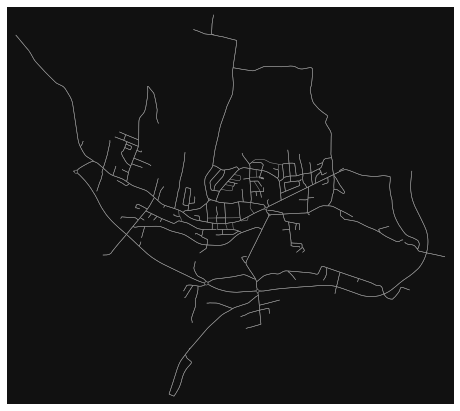

In [5]:
_ = ox.plot_graph(G,node_size=0, edge_linewidth=0.5)

In [13]:
skim = dict(nx.all_pairs_dijkstra_path_length(G, weight = 'length')) # may take some time

In [47]:
C = pd.DataFrame(skim).dropna()
C = C.reset_index(drop=True).T.reset_index(drop=True).T
C=(C/1000).round(2)

<AxesSubplot:>

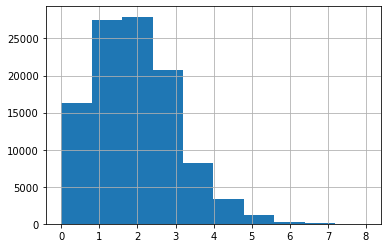

In [48]:
C.stack().hist()

17654
Iteration: 0	 total: 17654.00	 error_O: 0.00	 error_D: 3431.33
Iteration: 1	 total: 17654.00	 error_O: 0.00	 error_D: 0.00
Iteration: 2	 total: 17654.00	 error_O: 0.00	 error_D: 0.00
Iteration: 3	 total: 17654.00	 error_O: 0.00	 error_D: 0.00
Iteration: 4	 total: 17654.00	 error_O: 0.00	 error_D: 0.00
Iteration: 5	 total: 17654.00	 error_O: 0.00	 error_D: 0.00
Iteration: 6	 total: 17654.00	 error_O: 0.00	 error_D: 0.00


/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in reciprocal
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,0.079024,0.009261,0.048571,0.050639,0.067440,0.035096,0.076704,0.063649,0.012439,0.071040,...,0.023883,0.061831,0.069568,0.029362,0.024383,0.020952,0.057531,0.038877,0.014842,0.012290
1,0.473935,0.055543,0.291301,0.304004,0.404460,0.210697,0.460481,0.381729,0.074600,0.426054,...,0.143236,0.371195,0.417225,0.176096,0.146234,0.125658,0.345379,0.233157,0.089015,0.073707
2,0.186656,0.021875,0.114727,0.119730,0.159294,0.082981,0.181357,0.150341,0.029381,0.167798,...,0.056412,0.146192,0.164321,0.069354,0.057593,0.049489,0.136025,0.091827,0.035058,0.029029
3,0.581253,0.068121,0.357263,0.372470,0.496047,0.258149,0.564189,0.468169,0.091492,0.522531,...,0.175670,0.454794,0.511703,0.215971,0.179348,0.154112,0.423164,0.285954,0.109171,0.090398
4,0.358867,0.042016,0.220355,0.229964,0.306261,0.159382,0.348331,0.288760,0.056488,0.322289,...,0.108459,0.280791,0.315926,0.133341,0.110730,0.095054,0.261263,0.176372,0.067403,0.055756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.305055,0.059954,0.236460,0.246525,0.328316,0.166808,0.340595,0.302516,0.059120,0.337643,...,0.116270,0.301012,0.338678,0.181899,0.153336,0.131366,0.356761,0.240120,0.073422,0.082974
321,0.284372,0.063331,0.226687,0.236336,0.318547,0.155498,0.317185,0.282006,0.055111,0.314751,...,0.113262,0.292347,0.328600,0.207316,0.174588,0.149572,0.406205,0.273398,0.083681,0.076425
322,0.194160,0.042725,0.167498,0.174802,0.235607,0.106275,0.216780,0.192544,0.037628,0.214901,...,0.083772,0.216013,0.243043,0.153337,0.129130,0.110628,0.300442,0.202214,0.061831,0.051558
323,0.275326,0.060585,0.237756,0.247876,0.334101,0.150703,0.307403,0.273035,0.053412,0.305044,...,0.118793,0.306315,0.344645,0.217438,0.183112,0.156875,0.426039,0.286747,0.087767,0.073112


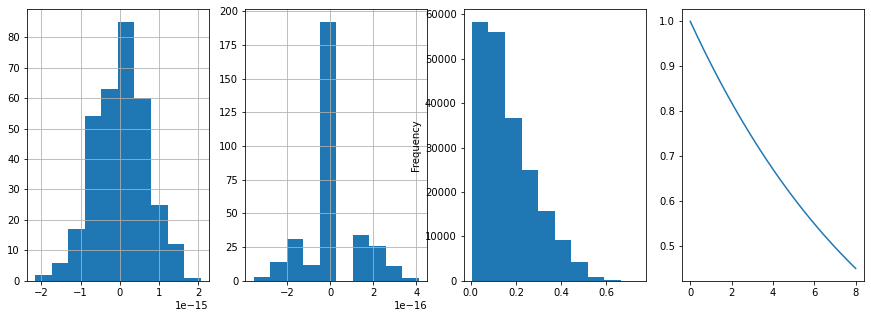

In [53]:
def mine(O, D, C, beta = 0.1, plot = True):
    def fun(x):
        return np.exp(-beta*x)
    print(O.sum())
    O = O.values # rows
    A = np.ones_like(O)
    D = D.values # columns
    B = np.ones_like(D)
    F = C.apply(np.vectorize(fun))
    for i in range(7):
        T = np.outer(O*A,D*B)*F
        A = np.reciprocal((B*D*F).sum(1))
        T = np.outer(O*A,D*B)*F       
        B = np.reciprocal((A*O*(F.T)).sum(1))
        if i % 1 ==0:
            print("Iteration: {}\t total: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f}".format(i,
                                                                             T.sum().sum(),
                                                                             ((T.sum(1)-O)**2).sum(),
                                                                             ((T.sum(0)-D)**2).sum()))
    if plot:
        fig, axes = plt.subplots(1,4,figsize = (15,5))
        axes = axes.flatten()
        #productions
        ((T.sum(1)-O)/O).hist(ax=axes[0])
        ((T.sum(0)-D)/D).hist(ax=axes[1])
        H = T.stack().to_frame()
        H.columns = ['flow']
        H['cost'] = C.stack()
        H['flow'].plot(kind='hist', weights = H['cost'], ax = axes[2])
        x=np.linspace(C.min().min(),C.max().max(), 200)
        axes[3].plot(x,fun(x))


    return T
#size = 500
O = np.random.randint(10,100,size=C.shape[0])
D = O.copy()
np.random.shuffle(D)
#C = pd.DataFrame(np.random.randint(10,20,size=(size,size)))
mine(pd.Series(O), pd.Series(D), C)
#T = mine(O,D,C) 

----
(c) Rafal Kucharski, 2022